In [2]:
# для генерации текста
!pip install accelerate -U
# для машинного перевода
!pip install transformers[sentencepiece]
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 543.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9af9affdfc546d86f7a4f33b8cd8941d2dd9e7882e0e2055204d9acb025bab09
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 4.0 MB/s eta 0:00:00


In [1]:
# модули работы с данными
import random
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from tqdm.notebook import tqdm
from collections import Counter
# модули для подготовки данных к обучению и оценки точности
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
# основной модуль для ML
import torch
# универсальная токенизация текста и токенизация под модели bert И gpt2
from transformers import AutoTokenizer, BertTokenizer, GPT2Tokenizer
# функция добавления слоя в предопученную модел для классификации текста
from transformers import  AutoModelForSequenceClassification
# функция загрузки модели для перевода текста
from transformers import AutoModelForSeq2SeqLM
# функция загрузки gpt-2 модели для генерации текста
from transformers import GPT2LMHeadModel, BertLMHeadModel
# модель автоматического заполнения пропущенных слов в предложениях
from transformers import pipeline

warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Применение BERT к задаче классификации отзывов клиентов.

In [ ]:
data = pd.read_csv('banki_clear.csv', usecols=['review', 'rating'])
data = data.drop([i for i in range(len(data['review'])) if not isinstance(data['review'][i], str)], axis=0)
BALANCE_NUM = 1500
one = data[data['rating'] == 1]
two = data[data['rating'] == 2]
three = data[data['rating'] == 3]
four = data[data['rating'] == 4]
five = data[data['rating'] == 5]
# баланс классов
data_balanced = pd.concat([one.sample(n=BALANCE_NUM, random_state=25),
                           five.sample(n=BALANCE_NUM, random_state=25),
                           two.sample(n=BALANCE_NUM, random_state=25, replace=True),
                           three.sample(n=BALANCE_NUM, random_state=25, replace=True),
                           four.sample(n=BALANCE_NUM, random_state=25, replace=True)])
# разбиение на выборки
X, y = data['review'], data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=25)
X, y = data_balanced['review'], data_balanced['rating']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size=.25, random_state=25)

## Обучение на классических моделях

Наилучший результат среди классических моделей даёт SVC, она не переобучается на дисбалансе и незначительно переобучается на балансированном, но по скорости обучения она значительно уступает другим моделям (около 15 минут против 1 минуты); результат на тренировочных несбалансированных данных показывает 89%, на балансированных 85%, что при небольшом объёме датасета, достаточно высокое значение.

## обучение через RNN

### Функции для обучения RNN:

In [ ]:
class EarlyStopping:
    """Класс преждевременной остановки для избежания переобучения"""
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance # количество уступок превышения разницы между потерями
        self.min_delta = min_delta # наибольшая разница между трен. и тест. потерями
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True

def train(model, train_loader, epoch, lr):
    """Универсальная функция обучения"""
    model.train() # режим обучения модели
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    Ys, Y_preds, losses = [], [], []
    for X, y in train_loader:
        preds = model.forward(X.to(device)) # прогон признаков через слои модели
        loss = criterion(preds, y.to(device)) # вычисление функции ошибки
        losses.append(loss.item()) # сохранение вычисленной ошибки
        Ys.append(y) # сохранение истинного значения класса
        Y_preds.append(preds.argmax(dim=1)) # сохранение индекса класса с наибольшей вероятностью
        optimizer.zero_grad() # очистка вычисленных градиентов
        loss.backward() # вычисление градиента функции потерь по всем параметрам модели
        optimizer.step() # оптимизация весов модели
    Ys = torch.cat(Ys).cpu().numpy()
    Y_preds = torch.cat(Y_preds).cpu().numpy()
    return torch.tensor(losses).mean(), accuracy_score(Ys, Y_preds) * 100

def test(model, test_loader):
    """Универсальная функция тестирования"""
    model.eval() # включение режима "тестирование" модели
    criterion = torch.nn.CrossEntropyLoss().to(device)
    with torch.no_grad(): #  не нужно вычислять градиенты для оптимизации весов
        Ys, Y_preds, losses = [], [], []
        for X, y in test_loader:
            preds = model(X.to(device))
            loss = criterion(preds, y.to(device))
            losses.append(loss.item())
            Ys.append(y)
            Y_preds.append(preds.argmax(dim=1))
    Ys = torch.cat(Ys).cpu().numpy()
    Y_preds = torch.cat(Y_preds).cpu().numpy()
    return torch.tensor(losses).mean(), accuracy_score(Ys, Y_preds) * 100

def train_test_model(num_epochs, model, train_loader, test_loader, learning_rate, tolerance, min_delta, model_name):
    """Функция обучения и тренировки модели"""
    early_stopping = EarlyStopping(tolerance=tolerance, min_delta=min_delta)
    train_losses, test_losses = [], []
    for epoch in range(1, num_epochs + 1):
        print("Epoch:{}".format(epoch), end=' | ')
        train_loss, train_acc = train(model, train_loader, epoch, learning_rate)
        print("train_loss:{:.2f} | train_accuracy:{:.2f}%".format(train_loss, train_acc), end=' | ')
        test_loss, test_acc = test(model, test_loader)
        print("test_loss:{:.2f} | test_accuracy:{:.2f}%".format(test_loss, test_acc))
        test_losses.append(test_loss)
        train_losses.append(train_loss)
        early_stopping(train_loss, test_loss)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
        torch.save(model, model_name)
    return train_losses, test_losses, epoch

def train_test_graph(epochs, train_losses, test_losses):
    """График функций ошибок на тренировчоных и тестовых данных"""
    plt.plot(range(epochs), train_losses, alpha=.5, color='#ADFF2F', label='Train')
    plt.plot(range(epochs), test_losses, alpha=.5, color='#32CD32', label='Test')
    plt.title("Train/test losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

### Подготовка DataLoader к обучению:

In [ ]:
vocab = build_vocab_from_iterator([sorted(Counter(data['review'].str.cat(sep=' ').split()))],
                                  min_freq=1, specials=["<unk>"])
print("Уникальных слов:", len(vocab))

def to_tensor(batch):
        """Функция для преобразования признаков и классов в Tensor"""
        X, Y = list(zip(*batch))
        X = [vocab(text.split()) for text in X]
        X = [tokens + ([0] * (50 - len(tokens))) if len(tokens) < 50 else tokens[:50] for tokens in X]
        return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1

class MyDataset(Dataset):

    def __init__(self, X: pd.Series, y: pd.Series):
        self.X: List[str] = list(X)
        self.y: List[int] = list(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, collate_fn=to_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, collate_fn=to_tensor)

train_dataset_b = MyDataset(X_train_b, y_train_b)
test_dataset_b = MyDataset(X_test_b, y_test_b)
train_loader_b = torch.utils.data.DataLoader(train_dataset_b, batch_size=1024, shuffle=True, collate_fn=to_tensor)
test_loader_b = torch.utils.data.DataLoader(test_dataset_b, batch_size=1024, shuffle=False, collate_fn=to_tensor)

Уникальных слов: 17333


### Создание и обучение RNN моделей:

In [ ]:
class MyRNN(torch.nn.Module):
    def __init__(self, vocab_size: int, # размер словаря
                 embedding_dim: int, # размер векторного представления слов
                 hidden_dim: int, hidden_dim2: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.emb = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, num_layers=1,
                                batch_first=True, dropout=.3)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim2)
        self.dropout = torch.nn.Dropout(.3)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(hidden_dim2, 5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, text: torch.tensor):
        x = self.emb(text)
        output, _ = self.rnn(x, torch.randn(1, len(text), self.hidden_dim).to(device))
        output = self.fc(output[:,-1])
        output = self.dropout(output)
        output = self.relu(output)
        output = self.fc1(output)
        output = self.softmax(output)
        return output

MyRNN(
  (emb): Embedding(17333, 4096)
  (rnn): RNN(4096, 512, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=512, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)
Epoch:1 | train_loss:1.25 | train_accuracy:66.88% | test_loss:1.18 | test_accuracy:72.57%
Epoch:2 | train_loss:1.16 | train_accuracy:74.53% | test_loss:1.13 | test_accuracy:77.38%
Epoch:3 | train_loss:1.13 | train_accuracy:76.97% | test_loss:1.13 | test_accuracy:77.21%
Epoch:4 | train_loss:1.13 | train_accuracy:77.58% | test_loss:1.13 | test_accuracy:77.35%
Epoch:5 | train_loss:1.13 | train_accuracy:77.33% | test_loss:1.13 | test_accuracy:77.32%
Epoch:6 | train_loss:1.13 | train_accuracy:77.58% | test_loss:1.14 | test_accuracy:76.35%
Epoch:7 | train_loss:1.13 | train_accuracy:77.64% | test_loss:1.13 | test_accuracy:77.05%
Epoch:8 | train_loss:1.13 | train_accuracy:77.95% | test_loss:1.14 

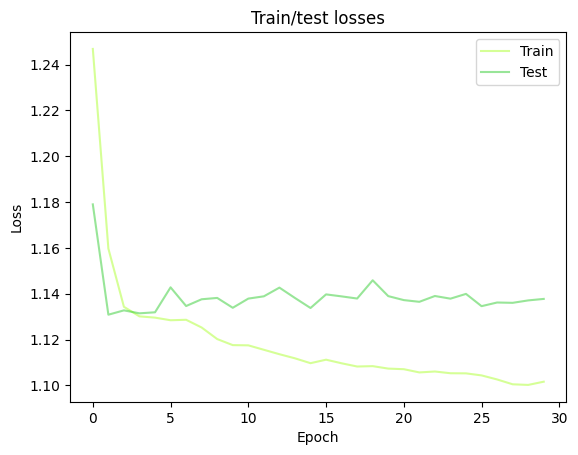

In [ ]:
EPOCHS = 30
model = MyRNN(len(vocab), 4_096, 512, 64).to(device)
print(model)
train_losses, test_losses, real_epoch = train_test_model(EPOCHS, model,
                                                         train_loader, test_loader, 1e-3,
                                                         2, .1, 'MyRnnDisbalance.pth')
train_test_graph(real_epoch, train_losses, test_losses)

MyRNN(
  (emb): Embedding(17333, 4096)
  (rnn): RNN(4096, 512, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=512, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)
Epoch:1 | train_loss:1.59 | train_accuracy:28.50% | test_loss:1.57 | test_accuracy:32.11%
Epoch:2 | train_loss:1.54 | train_accuracy:38.38% | test_loss:1.53 | test_accuracy:35.20%
Epoch:3 | train_loss:1.49 | train_accuracy:40.20% | test_loss:1.50 | test_accuracy:37.49%
Epoch:4 | train_loss:1.45 | train_accuracy:42.86% | test_loss:1.49 | test_accuracy:38.03%
Epoch:5 | train_loss:1.43 | train_accuracy:45.32% | test_loss:1.48 | test_accuracy:39.25%
Epoch:6 | train_loss:1.42 | train_accuracy:46.13% | test_loss:1.47 | test_accuracy:39.25%
Epoch:7 | train_loss:1.40 | train_accuracy:47.09% | test_loss:1.47 | test_accuracy:39.68%
Epoch:8 | train_loss:1.39 | train_accuracy:47.96% | test_loss:1.47 

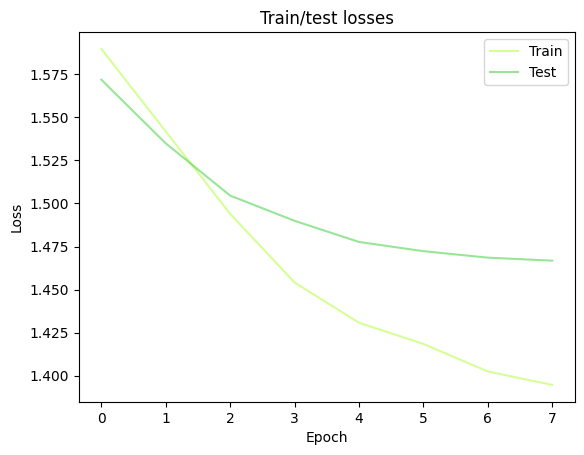

In [ ]:
model = MyRNN(len(vocab), 4_096, 512, 64).to(device)
print(model)
train_losses, test_losses, real_epoch = train_test_model(EPOCHS, model,
                                                         train_loader_b, test_loader_b, 1e-3,
                                                         3, .05, 'MyRnnBalance.pth')
train_test_graph(real_epoch, train_losses, test_losses)

RNN модель на дисбалансном датасете почти не переобучается, обучается быстро, но показывает результат ниже модели SVC; на сбалансированном датасете точность обучения ниже 50%, а также модель начинает сильно переобучаться уже после 3 эпохи, так что её приходится останавливать преждевременно.

## Обучение через SBert

### Функция для обучения и тестирования моделей и функция предсказания оценки

In [ ]:
def train_test(epochs, model, train_loader, test_loader, model_name):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
  for epoch in range(epochs):
      Ys, Y_preds, losses = [], [], []
      # Обучение модели
      model.train()
      for batch in tqdm(train_loader):
          optimizer.zero_grad()
          outputs = model(**{k: v.to(device) for k, v in batch.items()})
          loss = outputs.loss
          loss.backward()
          optimizer.step()
          Ys.append(batch['labels'].to(device))
          Y_preds.append(outputs.logits.argmax(dim=1))
          losses.append(loss.item())
      Ys = torch.cat(Ys).cpu().numpy()
      Y_preds = torch.cat(Y_preds).cpu().numpy()
      train_loss = torch.tensor(losses).mean()
      train_acc = accuracy_score(Ys, Y_preds) * 100
      print("train_loss:{:.2f} | train_accuracy:{:.2f}%".format(train_loss, train_acc))
      # Тестирование модели
      model.eval()
      with torch.no_grad():
          Ys, Y_preds, losses = [], [], []
          for batch in tqdm(test_loader):
              outputs = model(**{k: v.to(device) for k, v in batch.items()})
              loss = outputs.loss
              losses.append(loss.item())
              Ys.append(batch['labels'].to(device))
              Y_preds.append(outputs.logits.argmax(dim=1))
      Ys = torch.cat(Ys).cpu().numpy()
      Y_preds = torch.cat(Y_preds).cpu().numpy()
      test_loss = torch.tensor(losses).mean()
      test_acc = accuracy_score(Ys, Y_preds) * 100
      print("test_loss:{:.2f} | test_accuracy:{:.2f}%".format(test_loss, test_acc))

  torch.save(model, model_name)

def evaluate(model, tokenizer, text: str, my_rating: int):
  model.eval()
  test_dataset = MyDataset(tokenizer([text]), torch.tensor([my_rating]) - 1)
  test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
  with torch.no_grad():
    for batch in test_loader:
      outputs = model(**{k: v.to(device) for k, v in batch.items()})
      rating = outputs.logits.argmax(dim=1).item()
  print(text)
  print("Оценка отзыва:", my_rating,  "| Оценка моделью:", rating + 1)

class MyDataset(Dataset):
    """Подгон данных датасета под требования модели"""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### Загрузка и обучения Sbert на дисбалансе классов

In [ ]:
model_name = "ai-forever/sbert_large_nlu_ru"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5).to(device)

tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = MyDataset(tokenizer(list(X_train), padding=True),
                          torch.tensor(list(y_train)) - 1)
test_dataset = MyDataset(tokenizer(list(X_test), padding=True),
                         torch.tensor(list(y_test)) - 1)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
train_test(2, model, train_loader, test_loader, 'SbertUnbalanced.pth')

  0%|          | 0/4487 [00:00<?, ?it/s]

train_loss:0.45 | train_accuracy:87.22%


  0%|          | 0/1496 [00:00<?, ?it/s]

test_loss:0.40 | test_accuracy:88.26%


  0%|          | 0/4487 [00:00<?, ?it/s]

train_loss:0.37 | train_accuracy:89.57%


  0%|          | 0/1496 [00:00<?, ?it/s]

test_loss:0.39 | test_accuracy:88.82%


### Тестирование Sbert на дисбалансе классов

In [ ]:
model = torch.load('./drive/MyDrive/SbertUnbalanced.pth', map_location=torch.device('cpu'))
model_name = "ai-forever/sbert_large_nlu_ru"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
evaluate(model, tokenizer, 'Вторые сутки не могу получить выписки по своим 3 счетам , а именно : движение денежных средств за определённый период и остаток на конкретную дату Гарантию ни кто не даст, что вам предоставят нужные выписки ...', 1)
evaluate(model, tokenizer, 'Благодарю Тинькофф банк за быстрое реагирование на обращения клиентов. Помогли разобраться с вопросом по акции "Приведи друга" и начислили дополнительный бонус!', 5)
evaluate(model, tokenizer, 'Не предполагала, что придется негативный отзыв писать....печально. У всех банков есть вознаграждение за акцию "Приведи друга". Везде оно выплачивается по факту оформления карты другом, только в Совкомбанке при условии, что друг сделает покупку не своими, а ЗАЕМНЫМИ средствами.', 4)
evaluate(model, tokenizer, 'В целом банк очень нравится. Однако, наш бизнес из-за недопонимания с этой организацией серьёзно тормозится в развитии.', 2)

Вторые сутки не могу получить выписки по своим 3 счетам , а именно : движение денежных средств за определённый период и остаток на конкретную дату Гарантию ни кто не даст, что вам предоставят нужные выписки ...
Оценка отзыва: 1 | Оценка моделью: 1
Благодарю Тинькофф банк за быстрое реагирование на обращения клиентов. Помогли разобраться с вопросом по акции "Приведи друга" и начислили дополнительный бонус!
Оценка отзыва: 5 | Оценка моделью: 5
Не предполагала, что придется негативный отзыв писать....печально. У всех банков есть вознаграждение за акцию "Приведи друга". Везде оно выплачивается по факту оформления карты другом, только в Совкомбанке при условии, что друг сделает покупку не своими, а ЗАЕМНЫМИ средствами.
Оценка отзыва: 4 | Оценка моделью: 5
В целом банк очень нравится. Однако, наш бизнес из-за недопонимания с этой организацией серьёзно тормозится в развитии.
Оценка отзыва: 2 | Оценка моделью: 5


На дисбалансном датасете модель sbert обучается долго (час - одна эпоха на gpu), но показывает схожий результат с моделью svc в 89% точности на тестовых данных. Но может ошибаться при тестировании модели.

### Обучение Sbert на сбалансированном датасете

In [ ]:
model_name = "ai-forever/sbert_large_nlu_ru"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
train_dataset = MyDataset(tokenizer(list(X_train_b), padding=True),
                          torch.tensor(list(y_train_b)) - 1)
test_dataset = MyDataset(tokenizer(list(X_test_b), padding=True),
                         torch.tensor(list(y_test_b)) - 1)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
train_test(4, model, train_loader, test_loader, 'SbertBalanced.pth')

  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:1.26 | train_accuracy:39.86%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:1.09 | test_accuracy:51.73%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.87 | train_accuracy:61.87%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.71 | test_accuracy:69.97%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.49 | train_accuracy:80.55%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.68 | test_accuracy:73.97%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.24 | train_accuracy:91.31%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.67 | test_accuracy:79.15%


In [ ]:
model = torch.load('./drive/MyDrive/SbertBalanced.pth')
# дообучение модели
train_test(4, model, train_loader, test_loader, 'SbertBalanced.pth')

  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.15 | train_accuracy:95.08%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.76 | test_accuracy:79.20%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.09 | train_accuracy:97.08%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.87 | test_accuracy:78.03%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.08 | train_accuracy:97.35%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.88 | test_accuracy:78.99%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.08 | train_accuracy:97.56%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.73 | test_accuracy:85.01%


Модель сильно переобучается на более, чем 4 эпохах, так что для тестирования следует использовать только версию, до переобучения.

### Тестирование Sbert на балансе классов

In [ ]:
model = torch.load('./drive/MyDrive/SbertBalanced.pth', map_location=torch.device('cpu'))
model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
evaluate(model, tokenizer, 'Вторые сутки не могу получить выписки по своим 3 счетам , а именно : движение денежных средств за определённый период и остаток на конкретную дату Гарантию ни кто не даст, что вам предоставят нужные выписки ...', 1)
evaluate(model, tokenizer, 'Благодарю Тинькофф банк за быстрое реагирование на обращения клиентов. Помогли разобраться с вопросом по акции "Приведи друга" и начислили дополнительный бонус!', 5)
evaluate(model, tokenizer, 'Не предполагала, что придется негативный отзыв писать....печально. У всех банков есть вознаграждение за акцию "Приведи друга". Везде оно выплачивается по факту оформления карты другом, только в Совкомбанке при условии, что друг сделает покупку не своими, а ЗАЕМНЫМИ средствами.', 4)
evaluate(model, tokenizer, 'В целом банк очень нравится. Однако, наш бизнес из-за недопонимания с этой организацией серьёзно тормозится в развитии.', 2)

Вторые сутки не могу получить выписки по своим 3 счетам , а именно : движение денежных средств за определённый период и остаток на конкретную дату Гарантию ни кто не даст, что вам предоставят нужные выписки ...
Оценка отзыва: 1 | Оценка моделью: 1
Благодарю Тинькофф банк за быстрое реагирование на обращения клиентов. Помогли разобраться с вопросом по акции "Приведи друга" и начислили дополнительный бонус!
Оценка отзыва: 5 | Оценка моделью: 1
Не предполагала, что придется негативный отзыв писать....печально. У всех банков есть вознаграждение за акцию "Приведи друга". Везде оно выплачивается по факту оформления карты другом, только в Совкомбанке при условии, что друг сделает покупку не своими, а ЗАЕМНЫМИ средствами.
Оценка отзыва: 4 | Оценка моделью: 1
В целом банк очень нравится. Однако, наш бизнес из-за недопонимания с этой организацией серьёзно тормозится в развитии.
Оценка отзыва: 2 | Оценка моделью: 1


Точность падает по сравнению с предыдущей моделью, но выросла скорость обучения. При тестировании на входных данных показывает себя неэффективно.

## Обучение через RuBert-tiny на неочищенных данных

In [ ]:
data = pd.read_csv('banki.csv', usecols=['review', 'rating'])
data = data.drop([i for i in range(len(data['review'])) if not isinstance(data['review'][i], str)], axis=0)
BALANCE_NUM = 1500
one = data[data['rating'] == 1]
two = data[data['rating'] == 2]
three = data[data['rating'] == 3]
four = data[data['rating'] == 4]
five = data[data['rating'] == 5]
# баланс классов
data_balanced = pd.concat([one.sample(n=BALANCE_NUM, random_state=25),
                           five.sample(n=BALANCE_NUM, random_state=25),
                           two.sample(n=BALANCE_NUM, random_state=25, replace=True),
                           three.sample(n=BALANCE_NUM, random_state=25, replace=True),
                           four.sample(n=BALANCE_NUM, random_state=25, replace=True)])
# разбиение на выборки
X, y = data['review'], data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=25)
X, y = data_balanced['review'], data_balanced['rating']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size=.25, random_state=25)

### Обучение на балансе классов

In [ ]:
model_name = "cointegrated/rubert-tiny"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
train_dataset = MyDataset(tokenizer(list(X_train_b), padding=True, truncation=True,
                                    max_length=50, add_special_tokens = True),
                          torch.tensor(list(y_train_b)) - 1)
test_dataset = MyDataset(tokenizer(list(X_test_b), padding=True, truncation=True,
                                   max_length=50, add_special_tokens = True),
                         torch.tensor(list(y_test_b)) - 1)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
train_test(20, model, train_loader, test_loader, 'RubertBalanced.pth')

  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:1.46 | train_accuracy:33.00%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:1.38 | test_accuracy:37.28%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:1.35 | train_accuracy:39.84%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:1.30 | test_accuracy:41.55%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:1.25 | train_accuracy:45.78%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:1.30 | test_accuracy:43.25%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:1.14 | train_accuracy:51.25%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:1.16 | test_accuracy:49.97%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:1.04 | train_accuracy:56.18%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:1.08 | test_accuracy:54.35%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.92 | train_accuracy:61.94%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:1.01 | test_accuracy:57.60%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.82 | train_accuracy:66.52%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.95 | test_accuracy:60.32%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.71 | train_accuracy:70.88%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.92 | test_accuracy:62.19%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.64 | train_accuracy:74.40%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.89 | test_accuracy:66.35%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.56 | train_accuracy:77.65%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.86 | test_accuracy:67.52%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.50 | train_accuracy:80.66%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.86 | test_accuracy:69.49%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.44 | train_accuracy:83.56%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.84 | test_accuracy:70.19%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.37 | train_accuracy:86.12%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.86 | test_accuracy:72.11%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.33 | train_accuracy:87.89%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.85 | test_accuracy:73.28%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.28 | train_accuracy:89.56%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.85 | test_accuracy:74.19%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.24 | train_accuracy:91.40%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.87 | test_accuracy:74.93%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.21 | train_accuracy:93.01%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.91 | test_accuracy:74.19%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.17 | train_accuracy:94.35%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.90 | test_accuracy:75.89%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.14 | train_accuracy:95.22%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.99 | test_accuracy:73.65%


  0%|          | 0/1407 [00:00<?, ?it/s]

train_loss:0.12 | train_accuracy:96.32%


  0%|          | 0/469 [00:00<?, ?it/s]

test_loss:0.98 | test_accuracy:75.79%


### Тестирование на балансе классов

In [ ]:
model = torch.load('./drive/MyDrive/RubertBalanced.pth', map_location=torch.device('cpu'))
model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
evaluate(model, tokenizer, 'Вторые сутки не могу получить выписки по своим 3 счетам , а именно : движение денежных средств за определённый период и остаток на конкретную дату Гарантию ни кто не даст, что вам предоставят нужные выписки ...', 1)
evaluate(model, tokenizer, 'Благодарю Тинькофф банк за быстрое реагирование на обращения клиентов. Помогли разобраться с вопросом по акции "Приведи друга" и начислили дополнительный бонус!', 5)
evaluate(model, tokenizer, 'Не предполагала, что придется негативный отзыв писать....печально. У всех банков есть вознаграждение за акцию "Приведи друга". Везде оно выплачивается по факту оформления карты другом, только в Совкомбанке при условии, что друг сделает покупку не своими, а ЗАЕМНЫМИ средствами.', 4)
evaluate(model, tokenizer, 'В целом банк очень нравится. Однако, наш бизнес из-за недопонимания с этой организацией серьёзно тормозится в развитии.', 2)

Вторые сутки не могу получить выписки по своим 3 счетам , а именно : движение денежных средств за определённый период и остаток на конкретную дату Гарантию ни кто не даст, что вам предоставят нужные выписки ...
Оценка отзыва: 1 | Оценка моделью: 1
Благодарю Тинькофф банк за быстрое реагирование на обращения клиентов. Помогли разобраться с вопросом по акции "Приведи друга" и начислили дополнительный бонус!
Оценка отзыва: 5 | Оценка моделью: 4
Не предполагала, что придется негативный отзыв писать....печально. У всех банков есть вознаграждение за акцию "Приведи друга". Везде оно выплачивается по факту оформления карты другом, только в Совкомбанке при условии, что друг сделает покупку не своими, а ЗАЕМНЫМИ средствами.
Оценка отзыва: 4 | Оценка моделью: 1
В целом банк очень нравится. Однако, наш бизнес из-за недопонимания с этой организацией серьёзно тормозится в развитии.
Оценка отзыва: 2 | Оценка моделью: 4


Rubert-tiny на балансе классов обучается до точности в 75%, но достаточно сильно переобучается. В сравнении с предыдущей моделью на новых входных данных показывает себя лучше, но не лучше первой модели Sbert.

### Обучение на дисбалансе классов

In [ ]:
model_name = "cointegrated/rubert-tiny"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = MyDataset(tokenizer(list(X_train), padding=True, truncation=True,
                                    max_length=50, add_special_tokens = True),
                          torch.tensor(list(y_train)) - 1)
test_dataset = MyDataset(tokenizer(list(X_test), padding=True, truncation=True,
                                   max_length=50, add_special_tokens = True),
                         torch.tensor(list(y_test)) - 1)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
train_test(7, model, train_loader, test_loader, 'RubertUnbalanced.pth')

  0%|          | 0/4491 [00:00<?, ?it/s]

train_loss:0.71 | train_accuracy:76.22%


  0%|          | 0/1497 [00:00<?, ?it/s]

test_loss:0.63 | test_accuracy:78.94%


  0%|          | 0/4491 [00:00<?, ?it/s]

train_loss:0.59 | train_accuracy:80.58%


  0%|          | 0/1497 [00:00<?, ?it/s]

test_loss:0.60 | test_accuracy:80.51%


  0%|          | 0/4491 [00:00<?, ?it/s]

train_loss:0.55 | train_accuracy:82.78%


  0%|          | 0/1497 [00:00<?, ?it/s]

test_loss:0.59 | test_accuracy:81.31%


  0%|          | 0/4491 [00:00<?, ?it/s]

train_loss:0.52 | train_accuracy:83.87%


  0%|          | 0/1497 [00:00<?, ?it/s]

test_loss:0.59 | test_accuracy:81.35%


  0%|          | 0/4491 [00:00<?, ?it/s]

train_loss:0.49 | train_accuracy:84.72%


  0%|          | 0/1497 [00:00<?, ?it/s]

test_loss:0.60 | test_accuracy:81.73%


  0%|          | 0/4491 [00:00<?, ?it/s]

train_loss:0.46 | train_accuracy:86.04%


  0%|          | 0/1497 [00:00<?, ?it/s]

test_loss:0.62 | test_accuracy:80.68%


  0%|          | 0/4491 [00:00<?, ?it/s]

train_loss:0.43 | train_accuracy:87.12%


  0%|          | 0/1497 [00:00<?, ?it/s]

test_loss:0.63 | test_accuracy:81.46%


### Тестирование на дисбалансе классов

In [ ]:
model = torch.load('./drive/MyDrive/RubertUnbalanced.pth', map_location=torch.device('cpu'))
model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
evaluate(model, tokenizer, 'Вторые сутки не могу получить выписки по своим 3 счетам , а именно : движение денежных средств за определённый период и остаток на конкретную дату Гарантию ни кто не даст, что вам предоставят нужные выписки ...', 1)
evaluate(model, tokenizer, 'Благодарю Тинькофф банк за быстрое реагирование на обращения клиентов. Помогли разобраться с вопросом по акции "Приведи друга" и начислили дополнительный бонус!', 5)
evaluate(model, tokenizer, 'Не предполагала, что придется негативный отзыв писать....печально. У всех банков есть вознаграждение за акцию "Приведи друга". Везде оно выплачивается по факту оформления карты другом, только в Совкомбанке при условии, что друг сделает покупку не своими, а ЗАЕМНЫМИ средствами.', 4)
evaluate(model, tokenizer, 'В целом банк очень нравится. Однако, наш бизнес из-за недопонимания с этой организацией серьёзно тормозится в развитии.', 2)

Вторые сутки не могу получить выписки по своим 3 счетам , а именно : движение денежных средств за определённый период и остаток на конкретную дату Гарантию ни кто не даст, что вам предоставят нужные выписки ...
Оценка отзыва: 1 | Оценка моделью: 1
Благодарю Тинькофф банк за быстрое реагирование на обращения клиентов. Помогли разобраться с вопросом по акции "Приведи друга" и начислили дополнительный бонус!
Оценка отзыва: 5 | Оценка моделью: 5
Не предполагала, что придется негативный отзыв писать....печально. У всех банков есть вознаграждение за акцию "Приведи друга". Везде оно выплачивается по факту оформления карты другом, только в Совкомбанке при условии, что друг сделает покупку не своими, а ЗАЕМНЫМИ средствами.
Оценка отзыва: 4 | Оценка моделью: 1
В целом банк очень нравится. Однако, наш бизнес из-за недопонимания с этой организацией серьёзно тормозится в развитии.
Оценка отзыва: 2 | Оценка моделью: 5


На дисбалансе классов модель слабо переобучается. При тестировании показывает схожий результат с Sbert на дисбалансе, но всё равно уступает по эффективности.